In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [3]:
# tssa model
from src.ssa_methods.t_ssa import t_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.weather as weather_data

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [4]:
# names of observed signals
sig_names = ['Temperature', 'Precipitation', 'Pressure']
# measure units
sig_units = ['$^\circ C$', 'Mm', 'HPa']

num_signals = 3

In [5]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = weather_data.GetBerlinData(
    test_ratio=0.2
)

In [6]:
print(f'Train length = {train_data.shape[0]}')
print(f'Test length = {test_data.shape[0]}')

Train length = 2921
Test length = 731


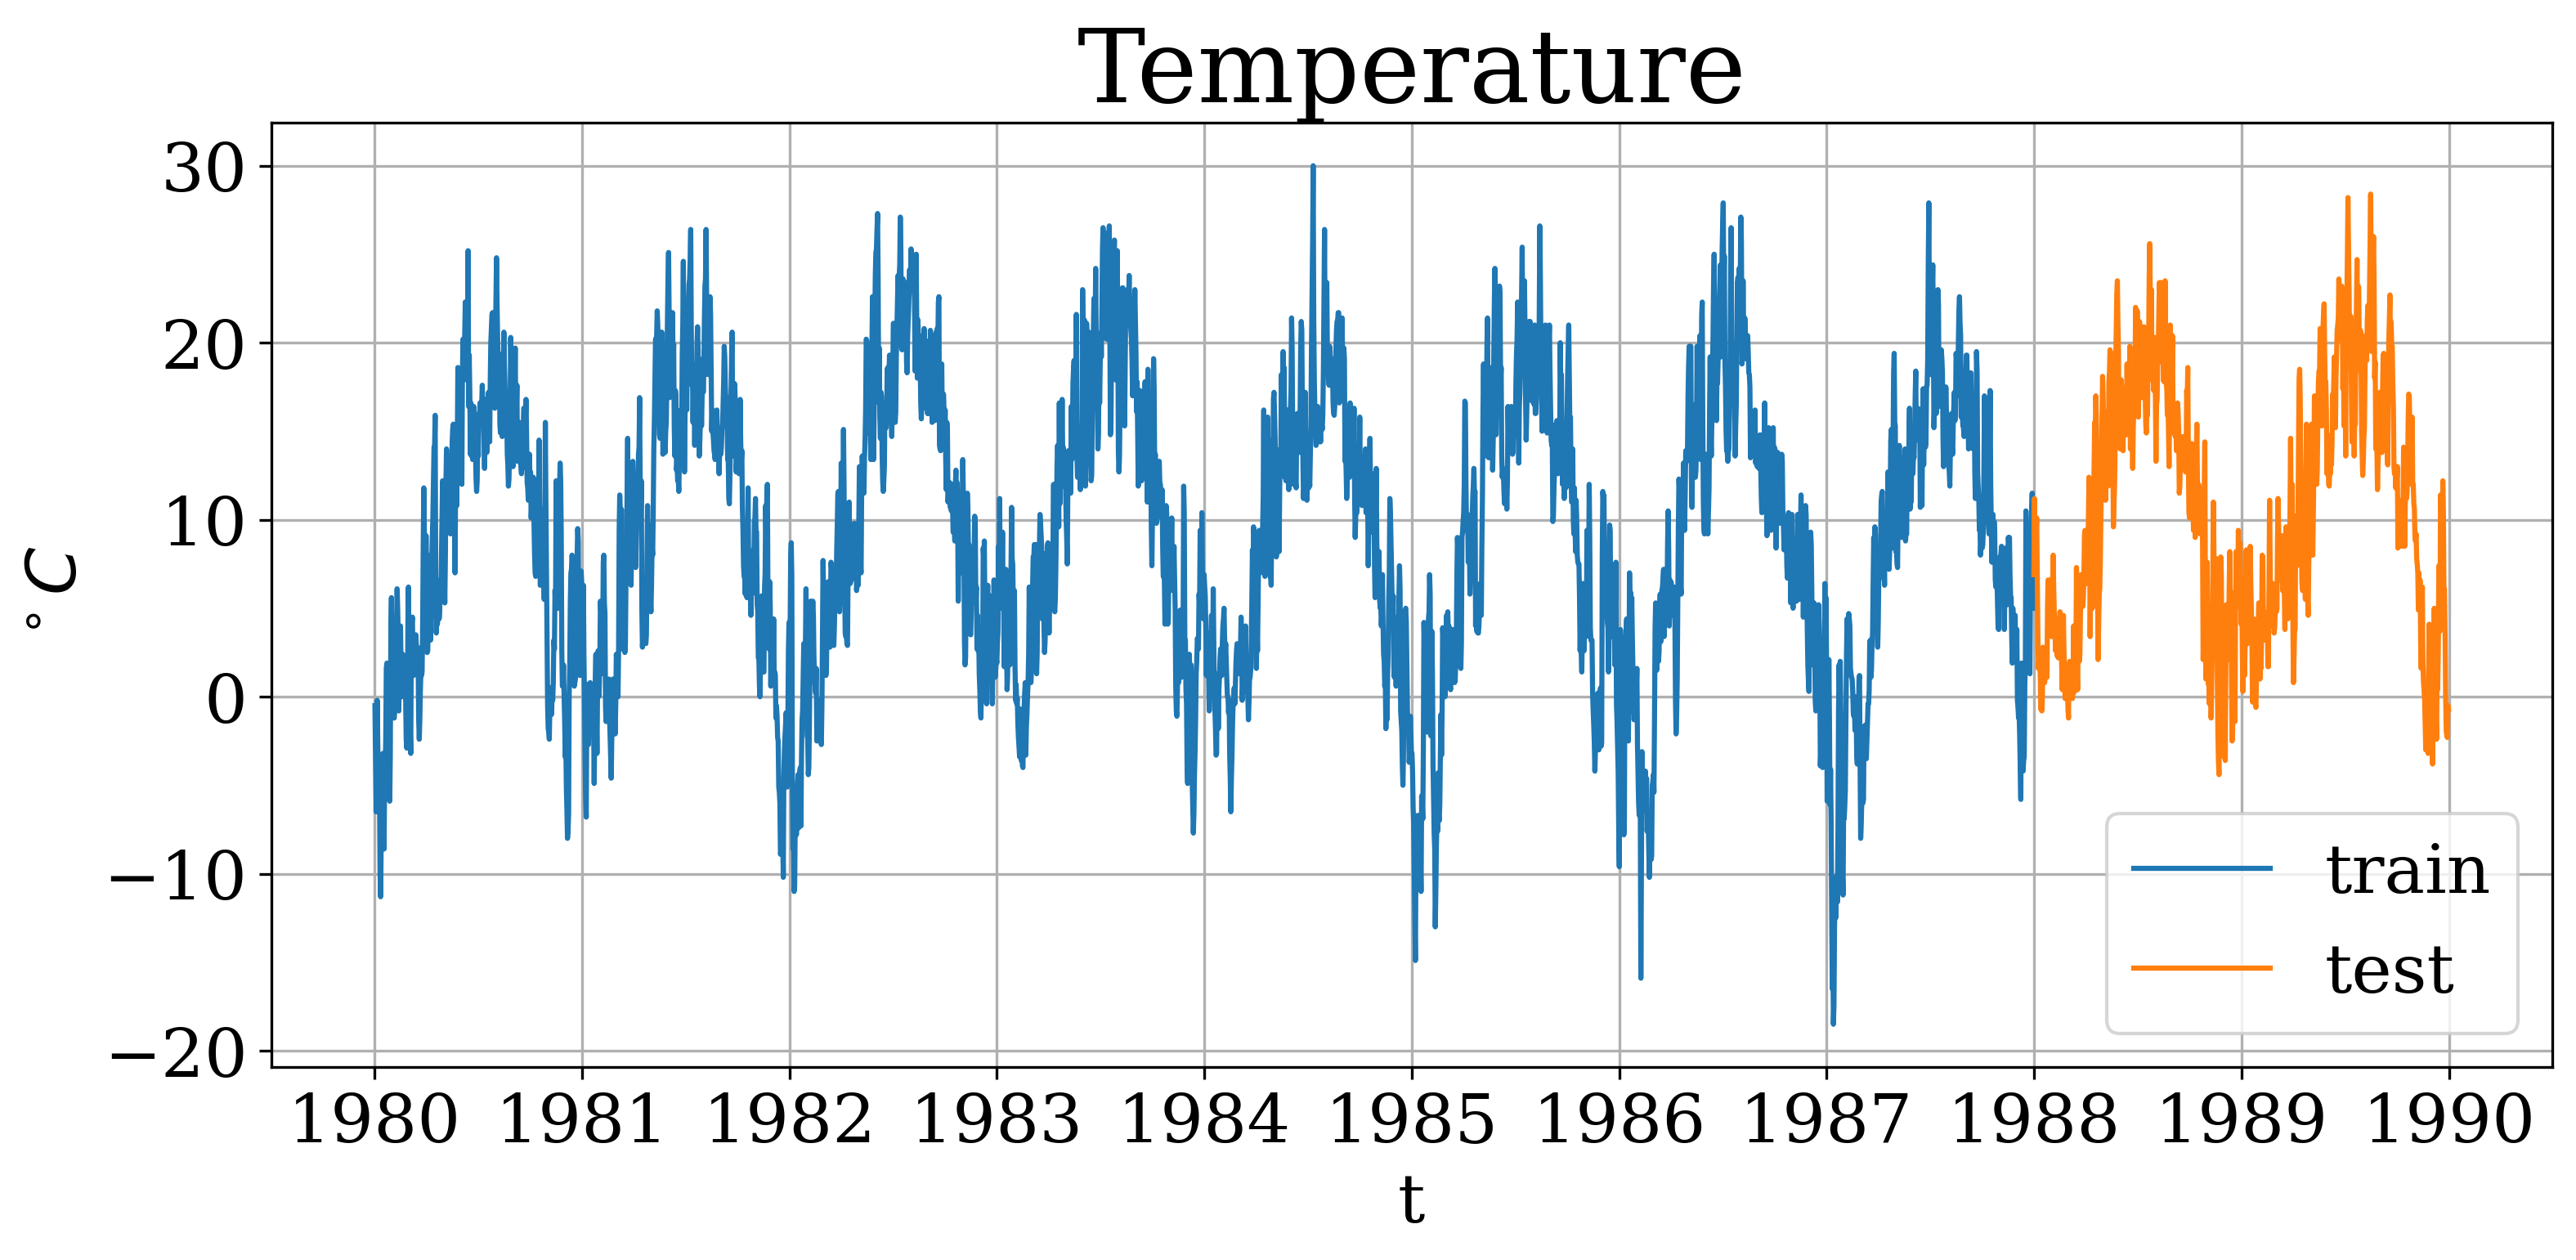

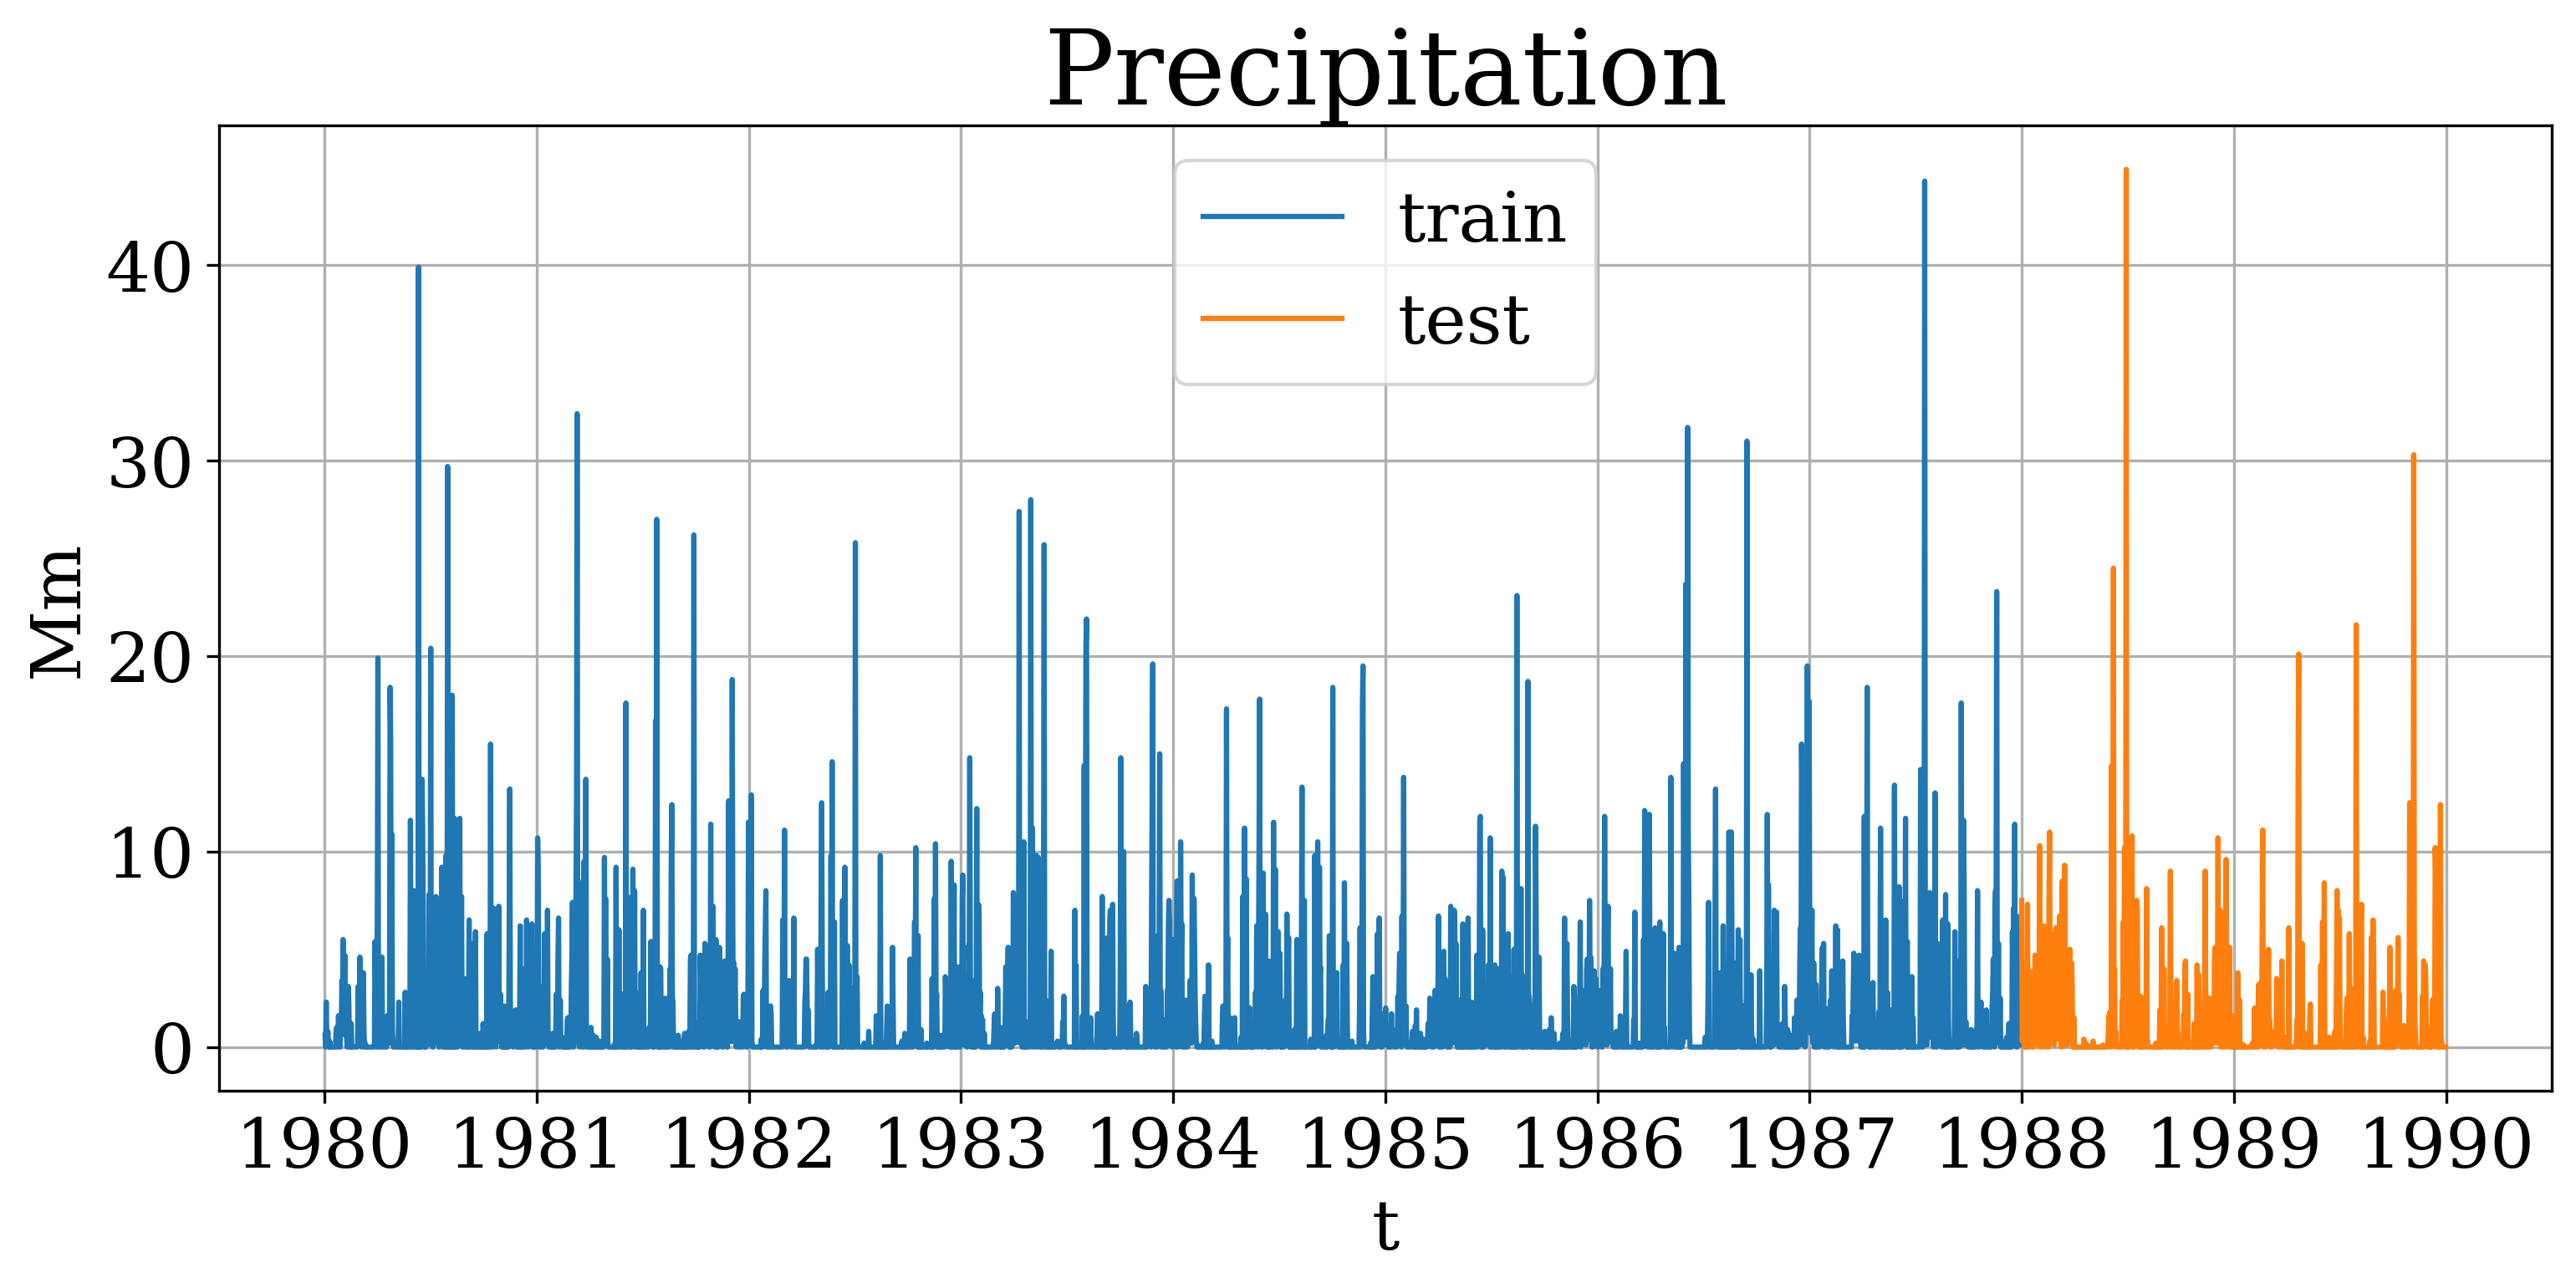

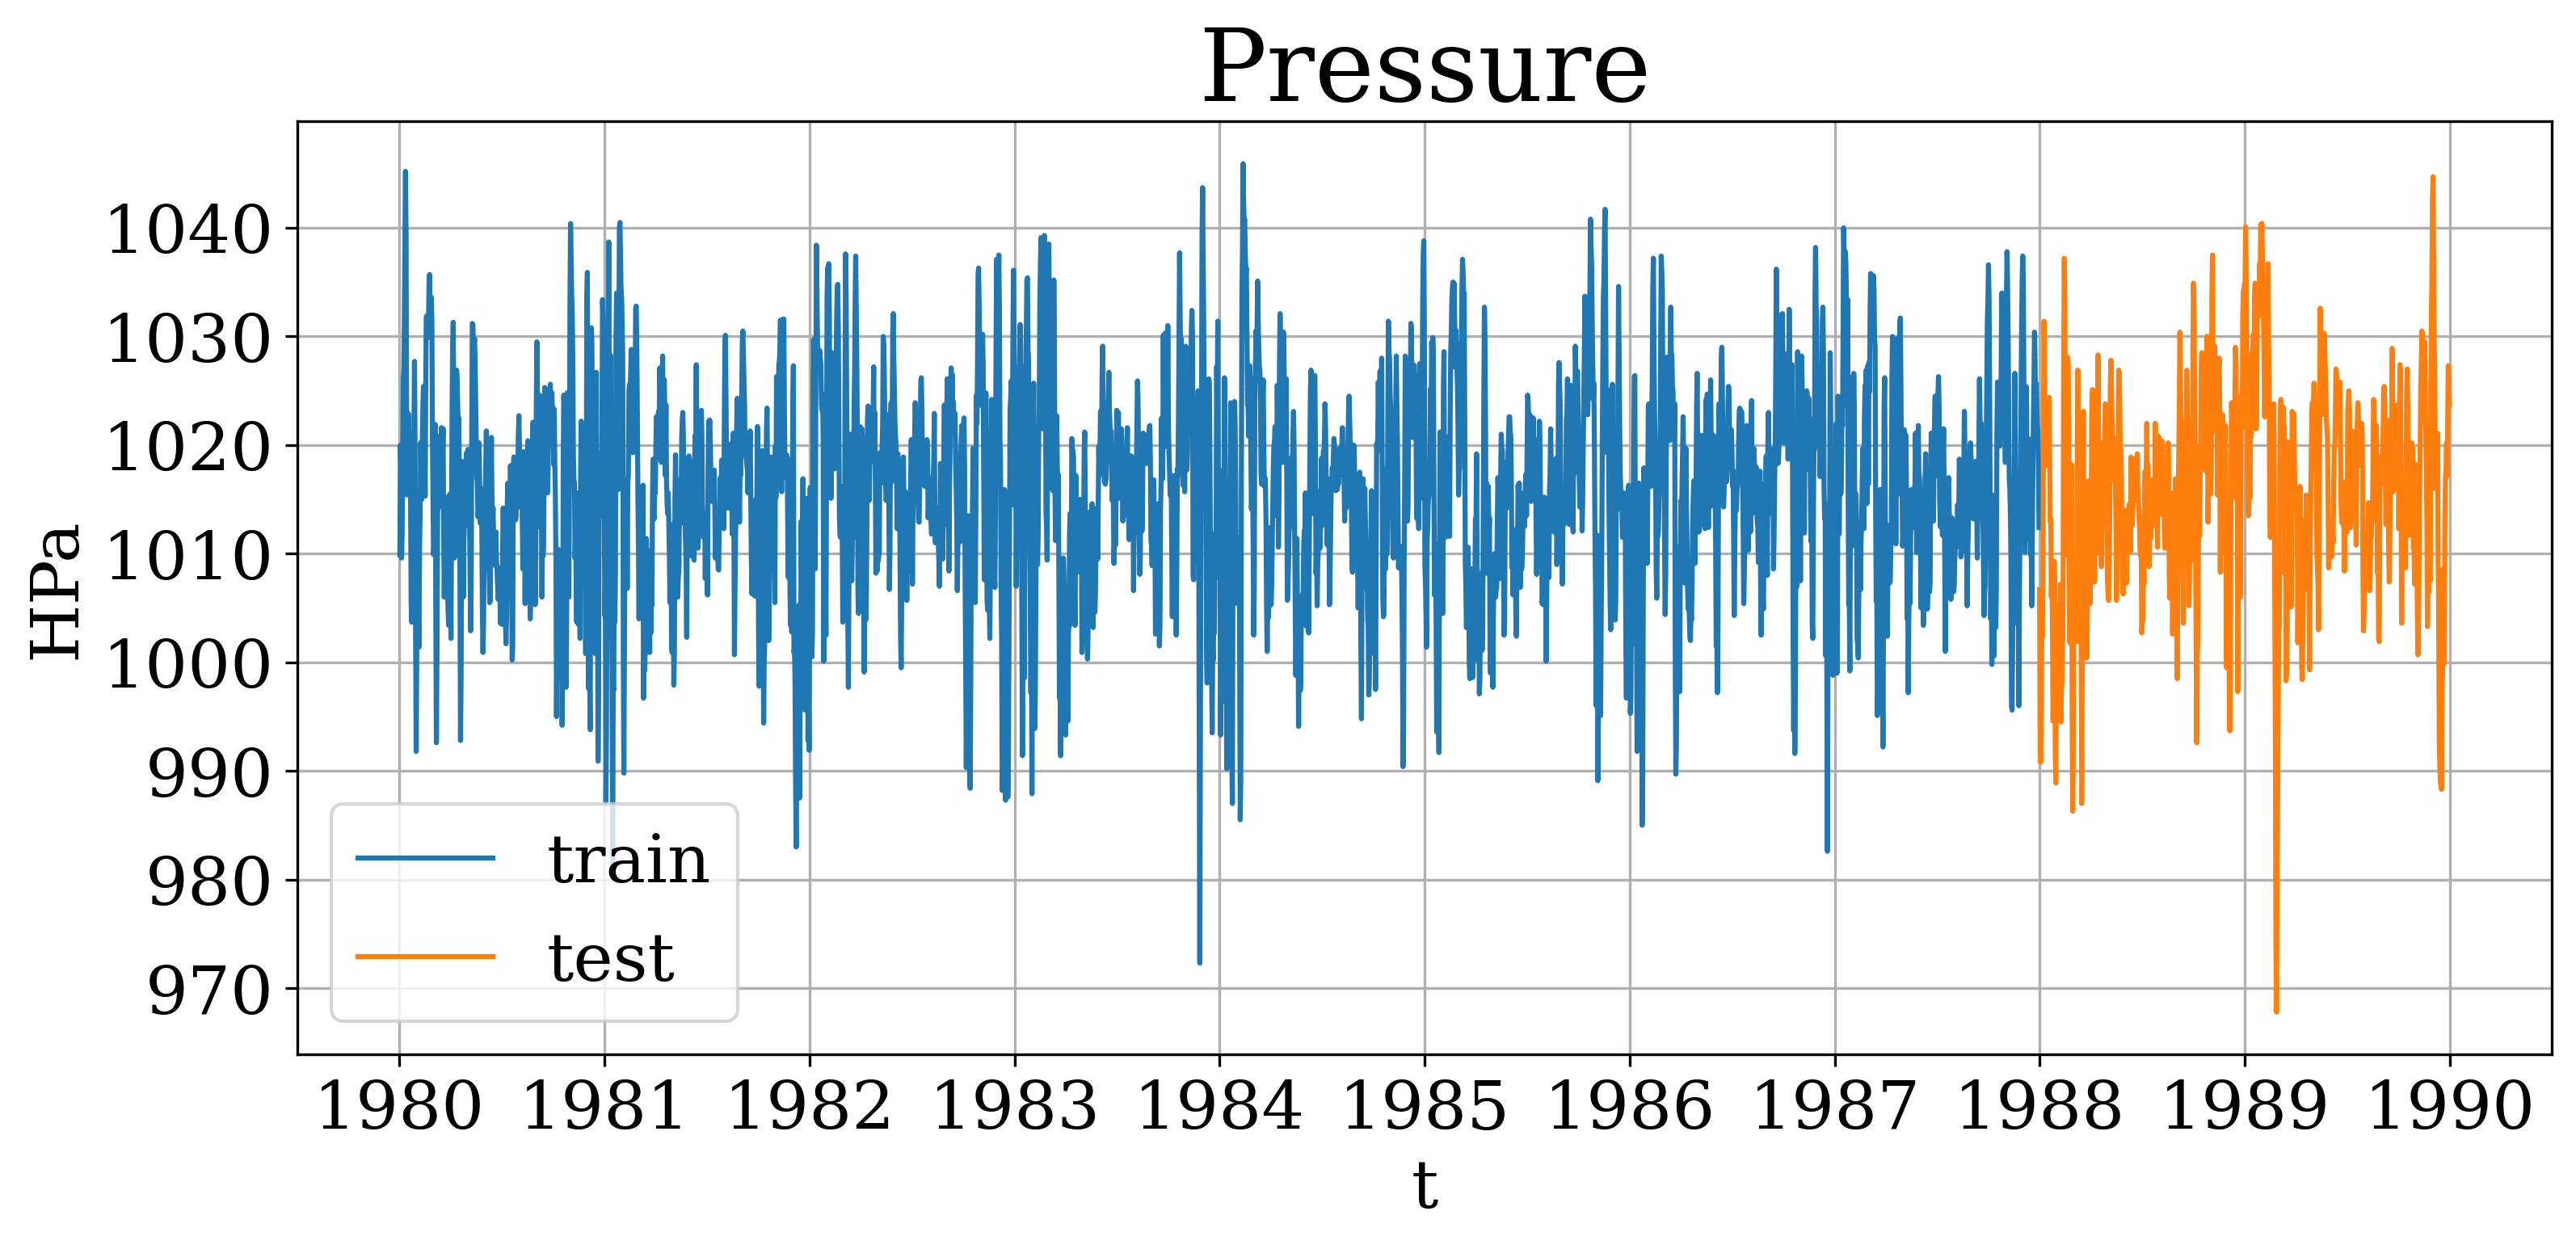

In [7]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

        fig.savefig(f"/home/cyrill/Sem8/Scientific_Work/figs/{sig_names[i]}.png", format='png')

## Global method parameters

In [12]:
# aka L parameter
ssa_window_size = 500

cpd_ranks = np.arange(5, 30 + 1, 5)
forecast_results = {key: {"mse": None, "mape": None} for key in cpd_ranks}

# parameter for detereministic behaviour of tSSA
random_state = 42

In [18]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#337357', '#EE4266']

## tSSA fitting

In [14]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

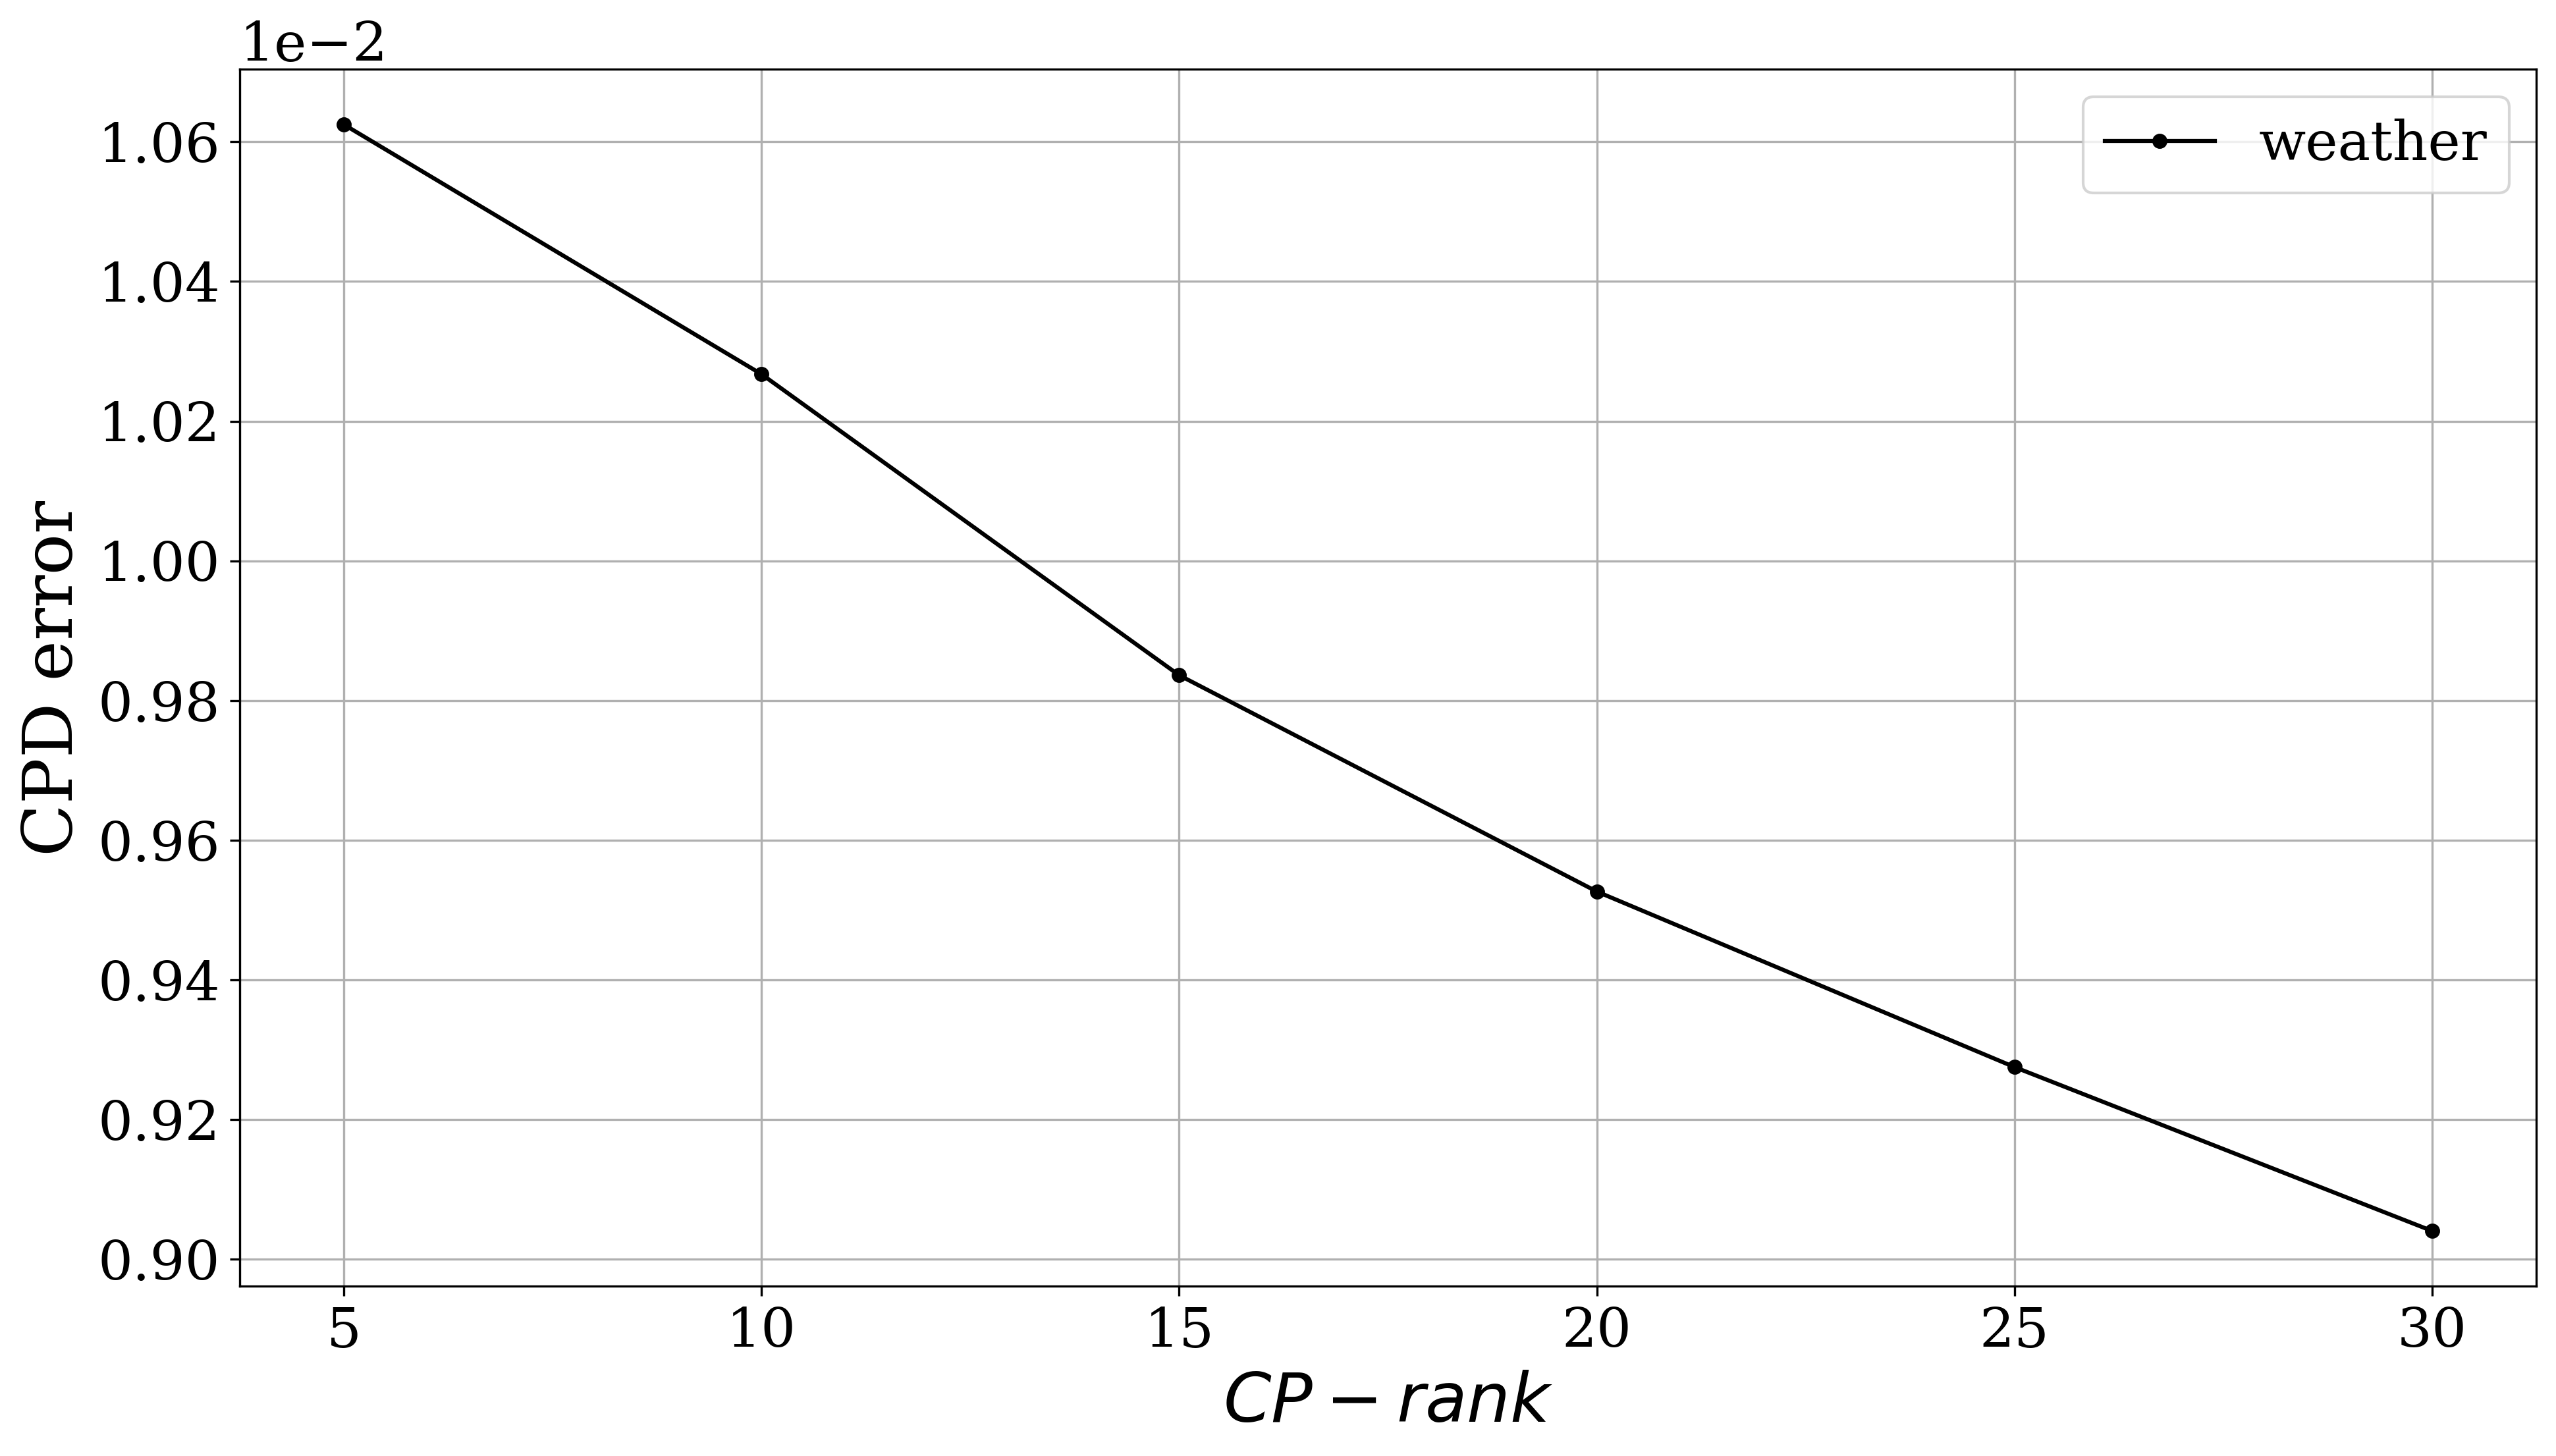

In [16]:
cpd_errors = []

for cpd_rank in cpd_ranks:
    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'rb') as f:
        t_ssa_obj: t_SSA = pickle.load(f)
    
    cpd_errors.append(t_ssa_obj.cpd_err_rel)

with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(cpd_ranks, cpd_errors, marker=".", color="black", label="weather")
    
    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"CPD error", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)

    ax.set_xticks(cpd_ranks)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig(f'./figs/CPD_error.png',
                         format='png')

In [ ]:
for cpd_rank in cpd_ranks:
    print(f"CP rank = {cpd_rank}")

    t_ssa_obj = t_SSA(ssa_window_size, train_data.T, cpd_rank)

    # make svd for common matrix, extract factors and singular values
    t_ssa_obj.decompose_tt(random_state=random_state)
    print(f"CPD-error = {t_ssa_obj.cpd_err_rel}")

    # save model
    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'wb') as f:
        pickle.dump(t_ssa_obj, f)

    t_ssa_obj.remove_last_predictions()

    # get prediction for cuurent number of factors left
    forecast_tssa = np.empty(test_data.shape)
    
    for i in range(test_data.shape[0]):
        forecast_tssa[i] = np.array(t_ssa_obj.predict_next())
    
    # get MSE for every signal
    signals_mse_tssa = np.mean((forecast_tssa - test_data) ** 2, axis=0)
    # get MAPE for every signal
    # to avoid zero-division
    eps = 1e-5
    signals_mape_tssa = []
    signals_mape = np.abs((forecast_tssa - test_data) / test_data)

    for i in range(signals_mape.shape[1]):
        cur_mape = signals_mape[:, i]
        cur_mape = cur_mape[~np.isinf(cur_mape)]
        signals_mape_tssa.append(
            cur_mape.mean()
        )

    signals_mape_tssa = np.array(signals_mape_tssa)

    forecast_results[cpd_rank]["mse"] = signals_mse_tssa
    forecast_results[cpd_rank]["mape"] = signals_mape_tssa
    
    print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
    print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa):e}')

In [15]:
with open(f"./saved_model/forecast_results", "wb") as f:
    pickle.dump(forecast_results, f)

In [21]:
with open(f"./saved_model/forecast_results", "rb") as f:
    forecast_results:dict = pickle.load(f)

    print(forecast_results[5])

{'mse': array([14.16832166, 11.02055751, 98.01649747]), 'mape': array([0.85034527, 3.15157778, 0.00730368])}


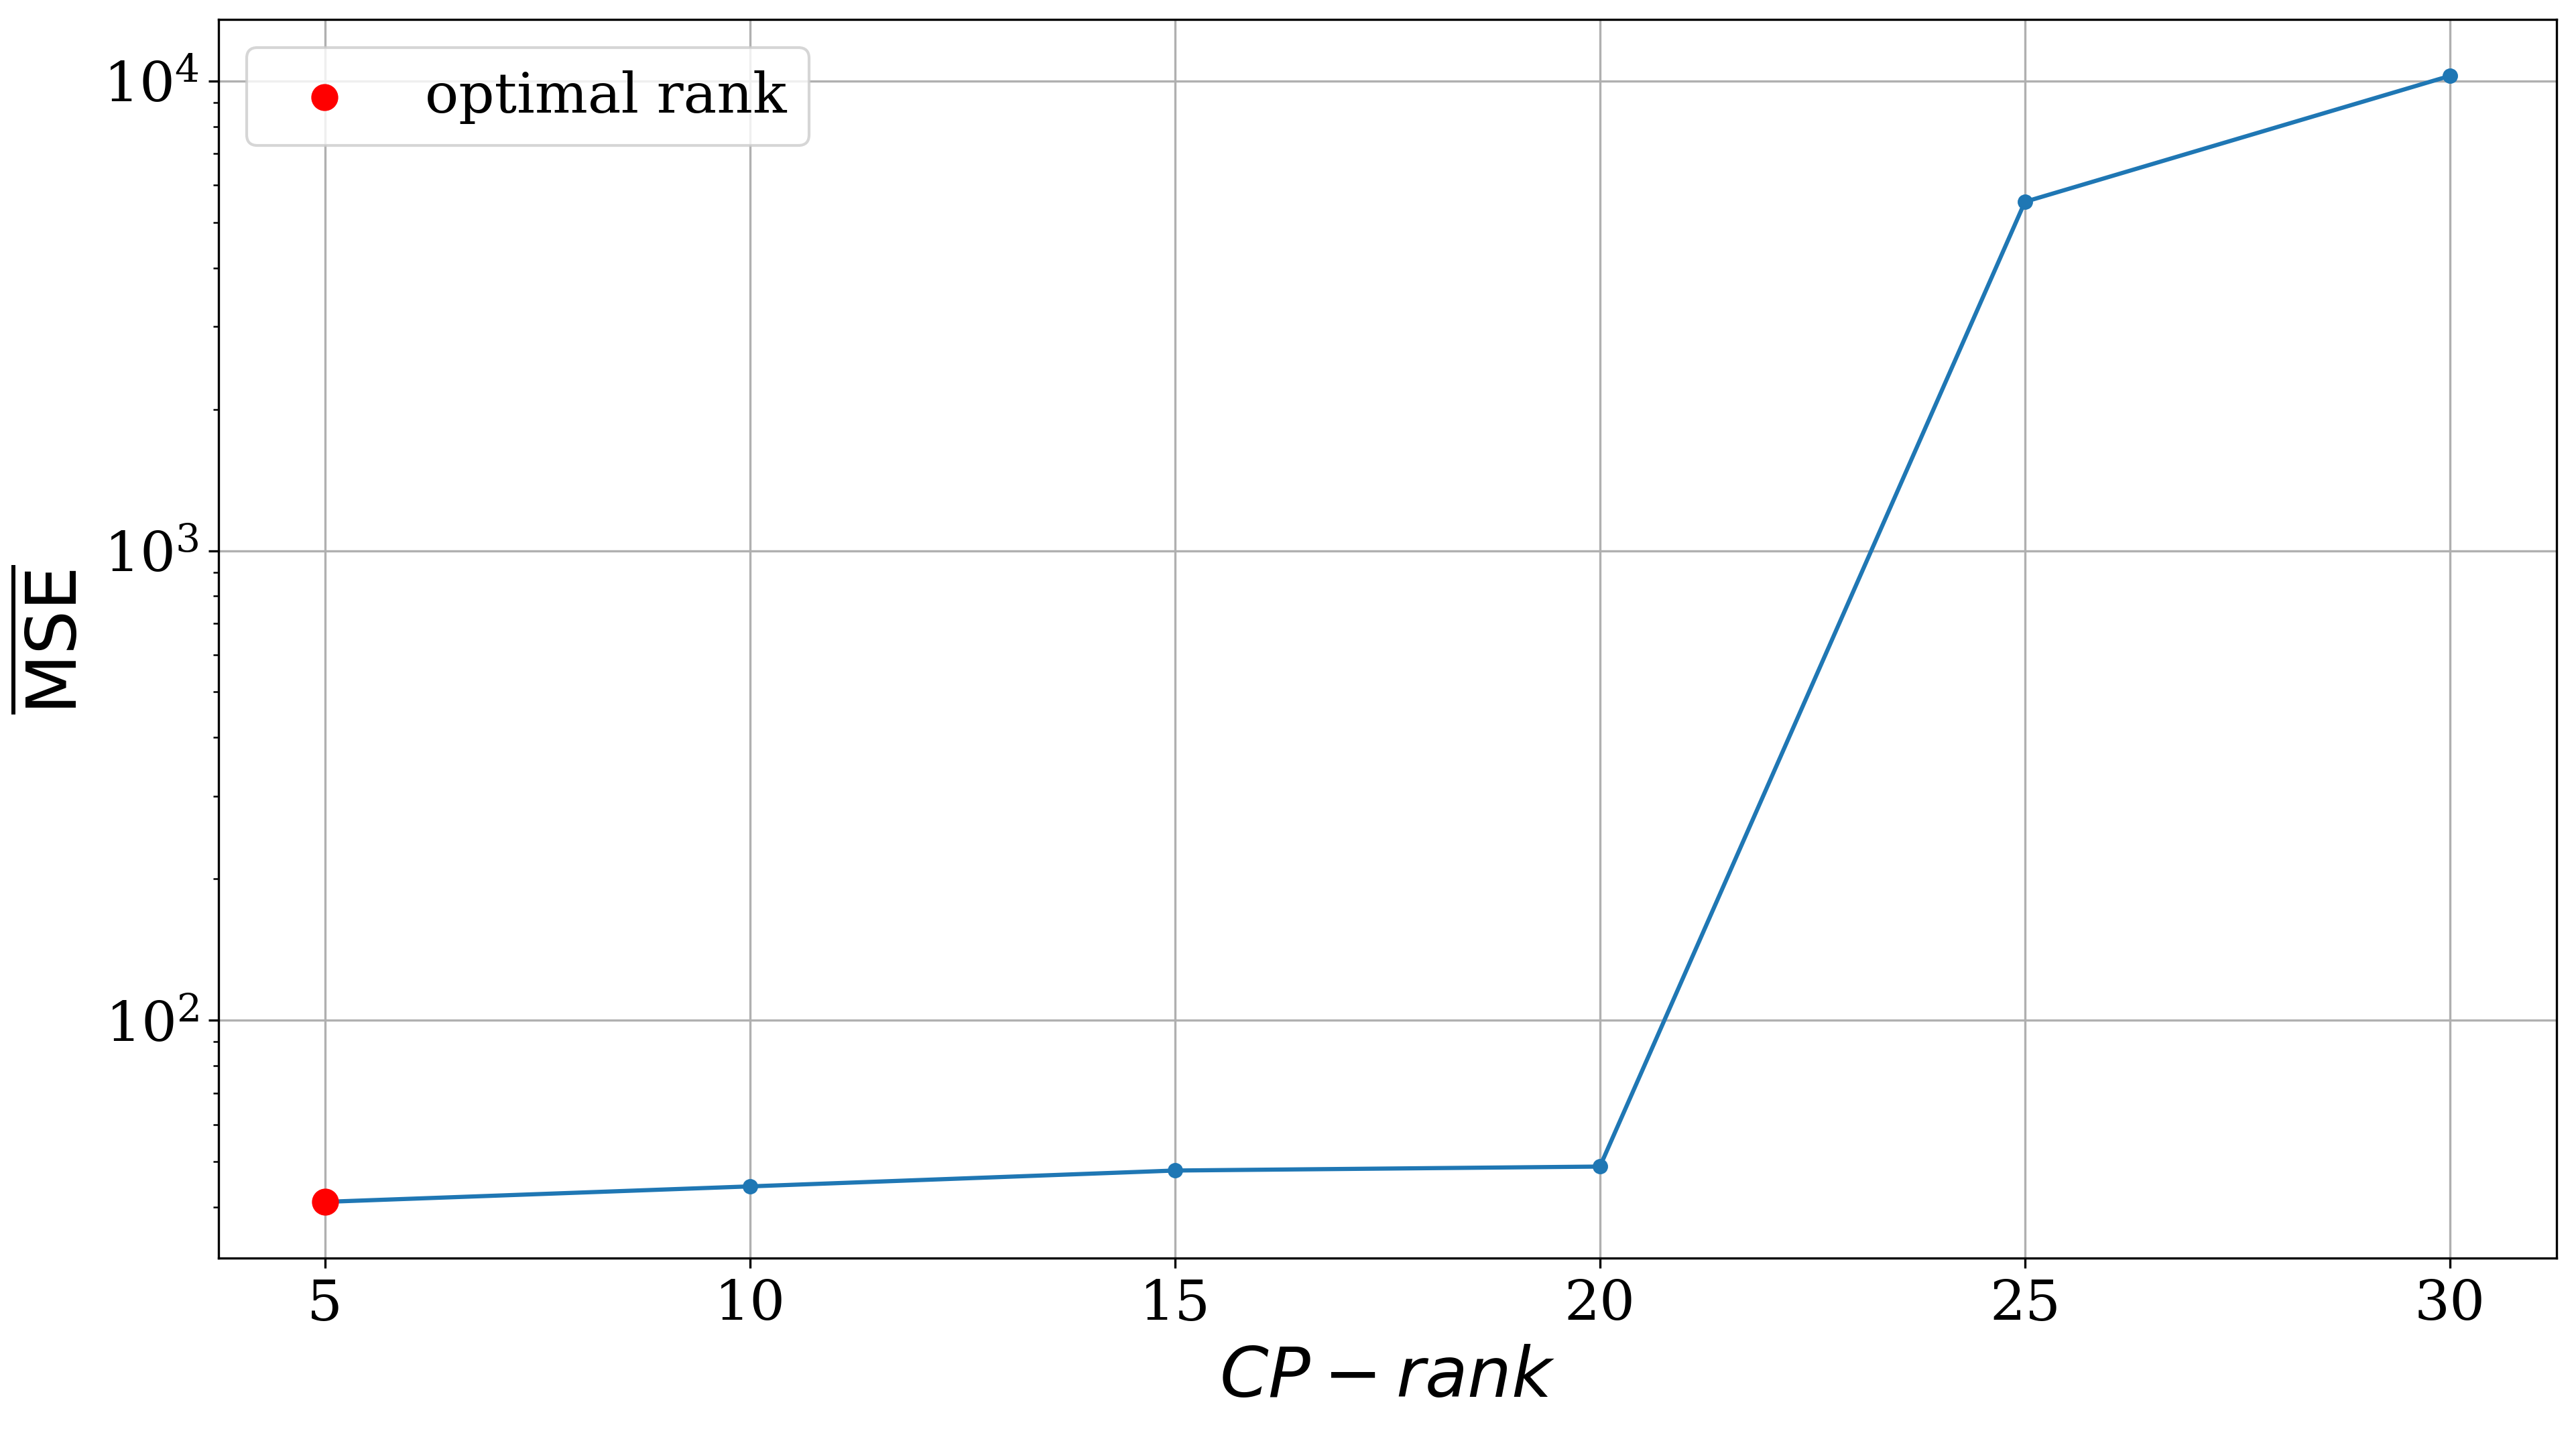

In [27]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    mean_mses = []
    for key, item in forecast_results.items():
        mean_mses.append(item["mse"].mean())

    ax.plot(forecast_results.keys(), mean_mses, marker=".")
    ax.scatter([5], [mean_mses[0]], marker=".", s=300, c="red", label="optimal rank", zorder=10)
    
    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{MSE}} $", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)
    ax.set_yscale("log")

    ax.set_xticks(list(forecast_results.keys()))
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig(f'./figs/prediction/MSE_rank.png',
                         format='png')

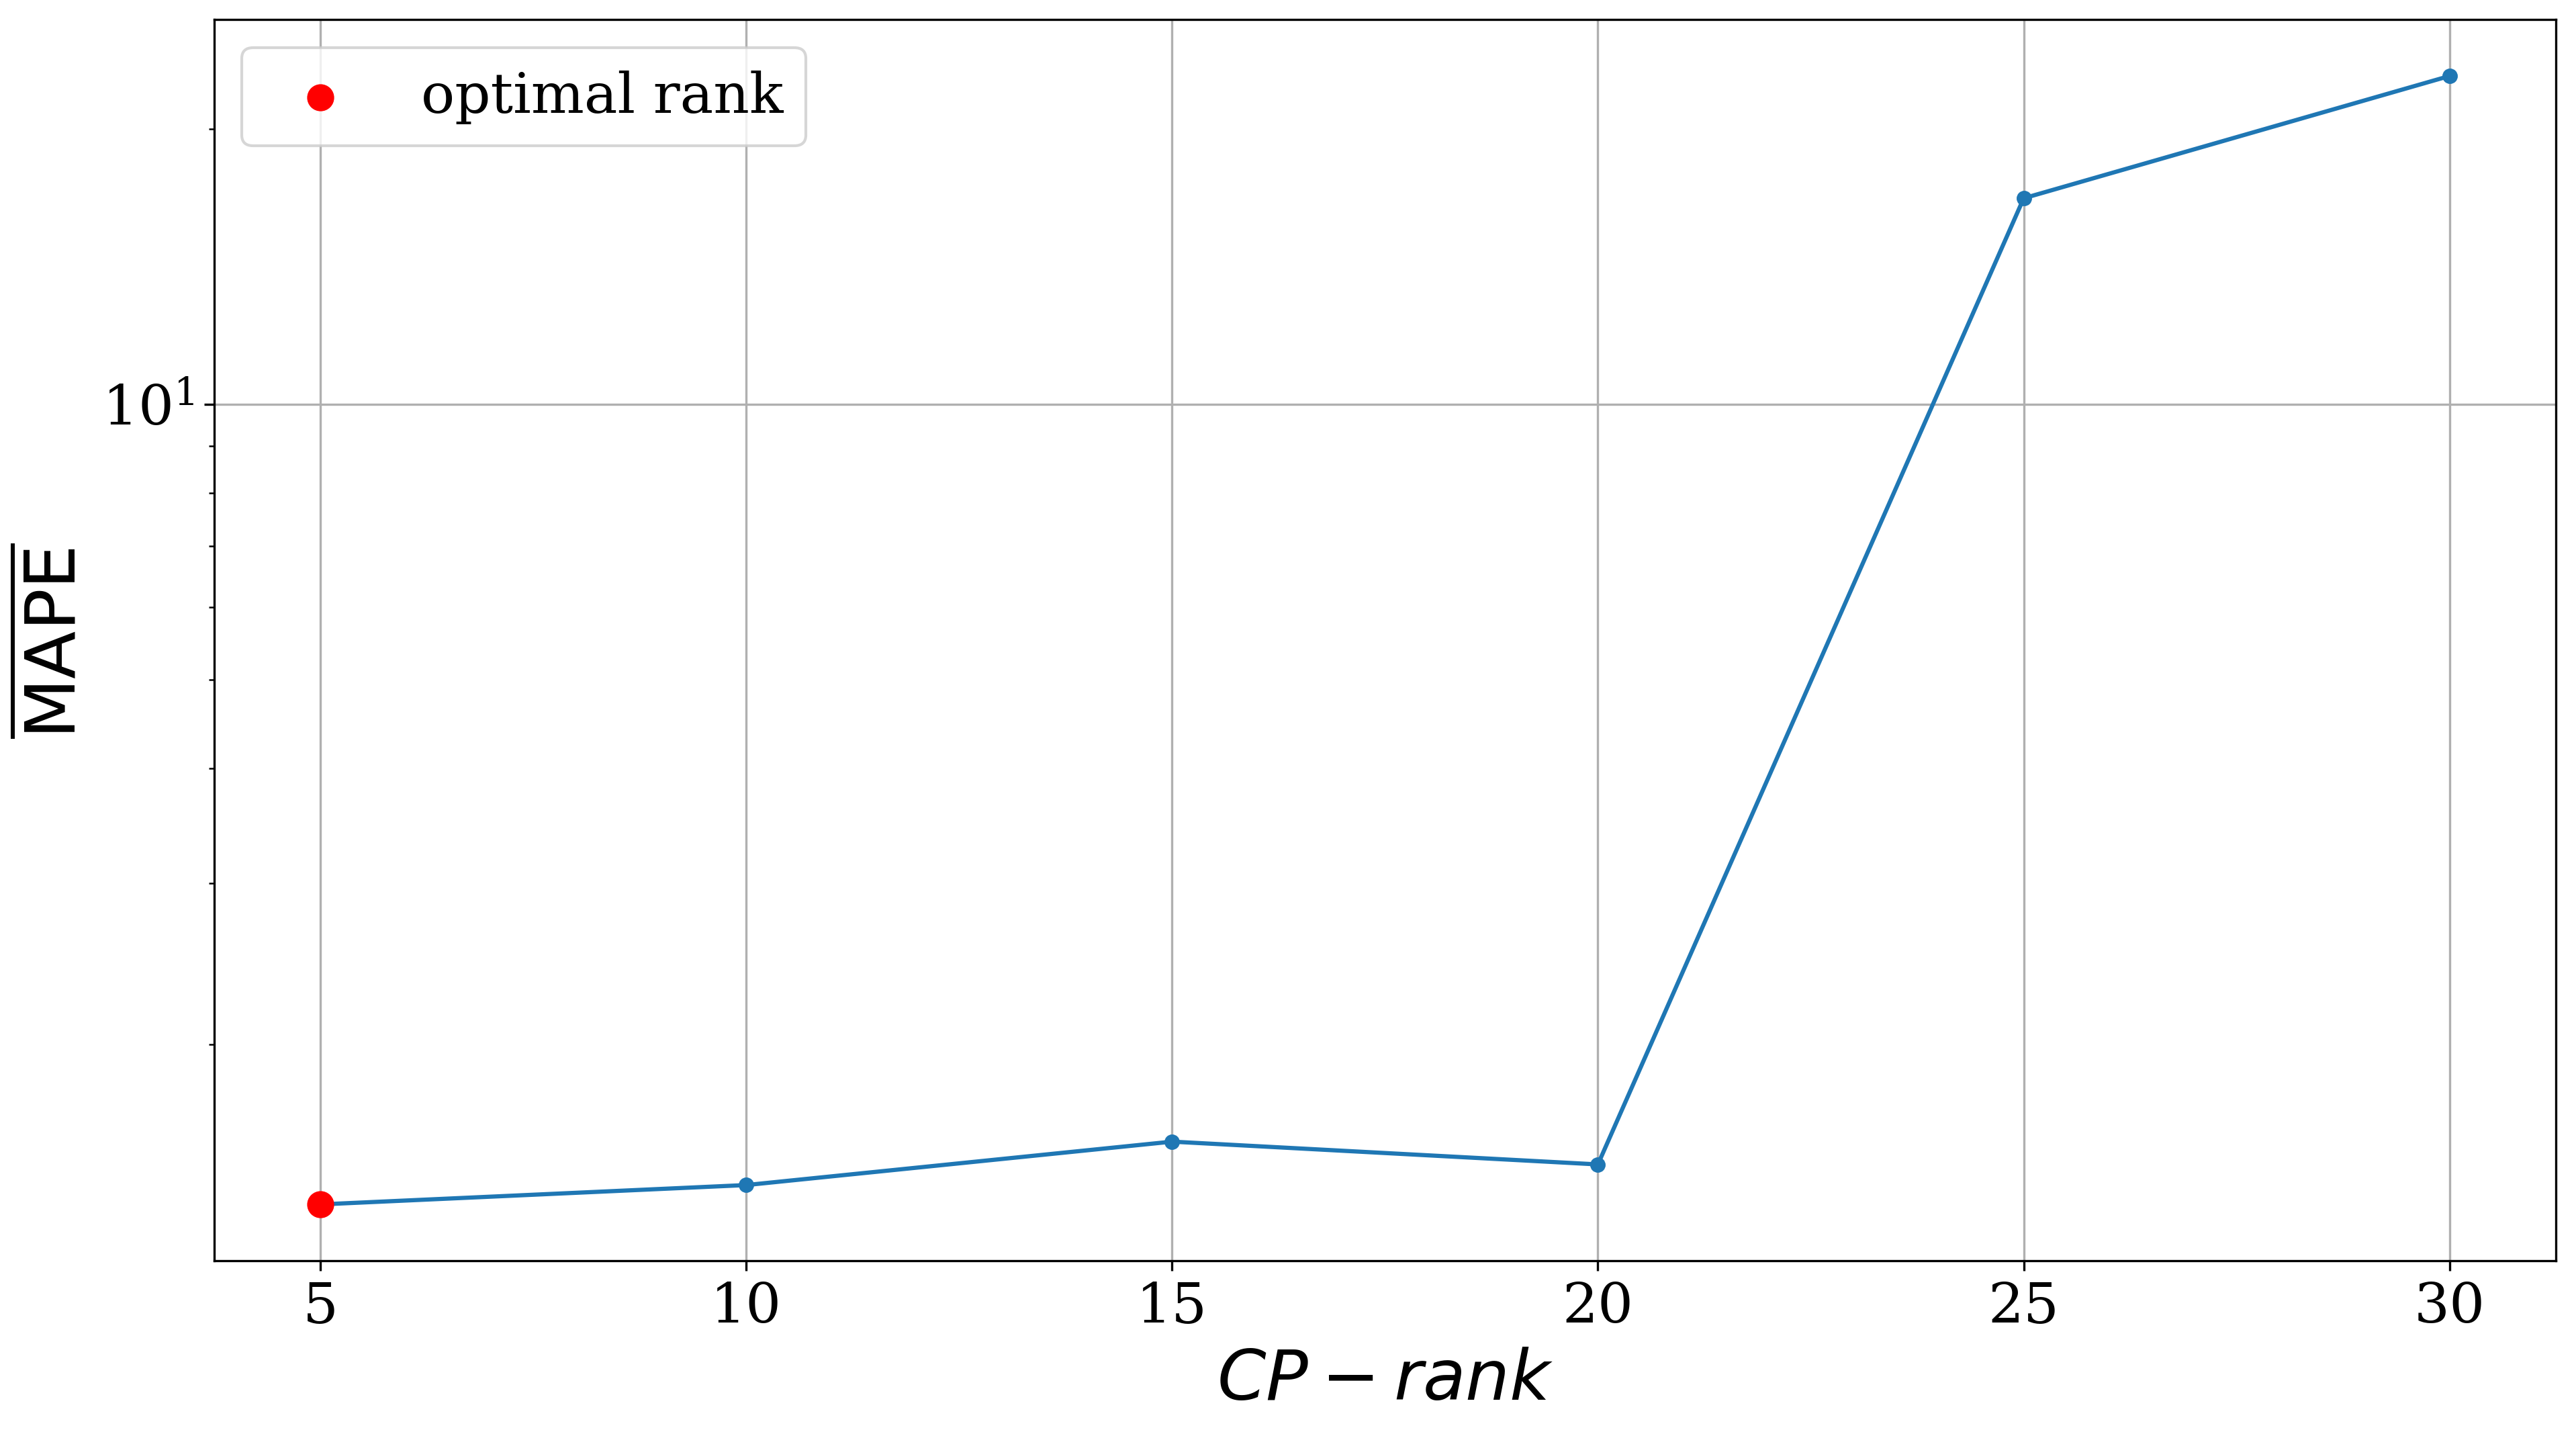

In [28]:
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    mean_mapes = []
    for key, item in forecast_results.items():
        mean_mapes.append(item["mape"].mean())

    ax.plot(forecast_results.keys(), mean_mapes, marker=".")
    ax.scatter([5], [mean_mapes[0]], marker=".", s=300, c="red", label="optimal rank", zorder=10)

    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{MAPE}} $", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)
    ax.set_yscale("log")

    ax.set_xticks(list(forecast_results.keys()))
    #ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig(f'./figs/prediction/MAPE_rank.png',
                         format='png')

## Prediction

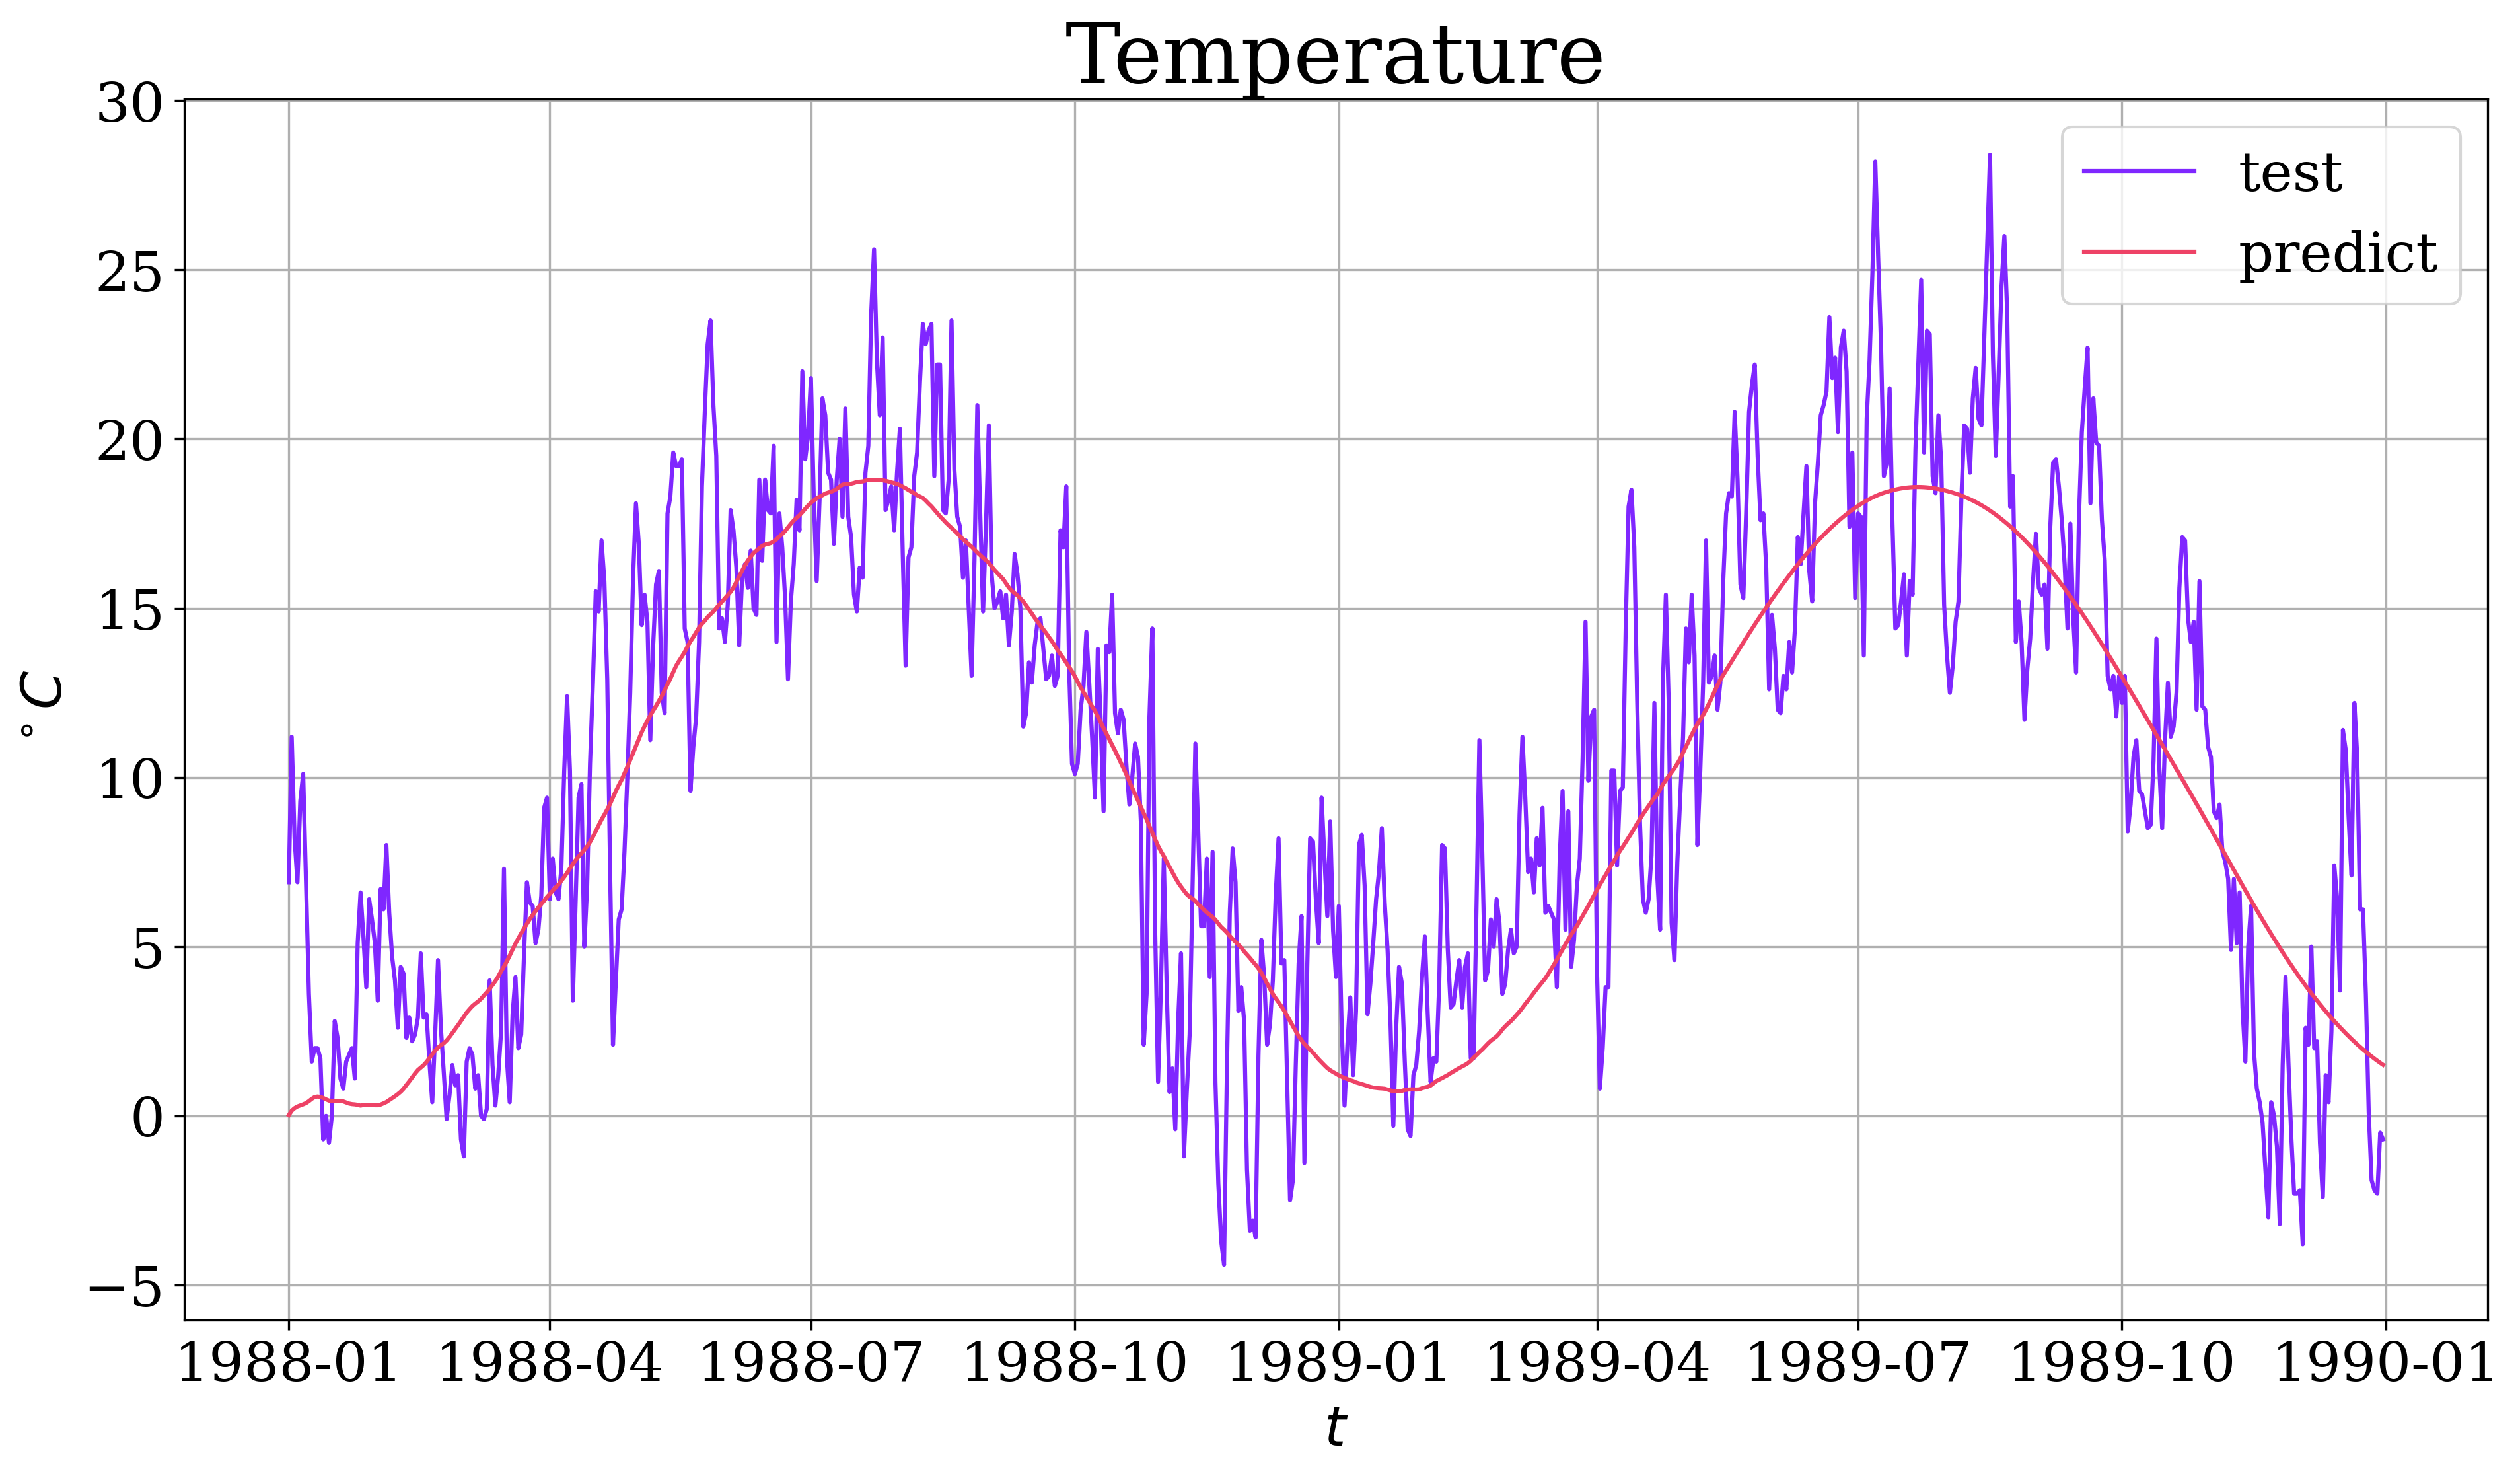

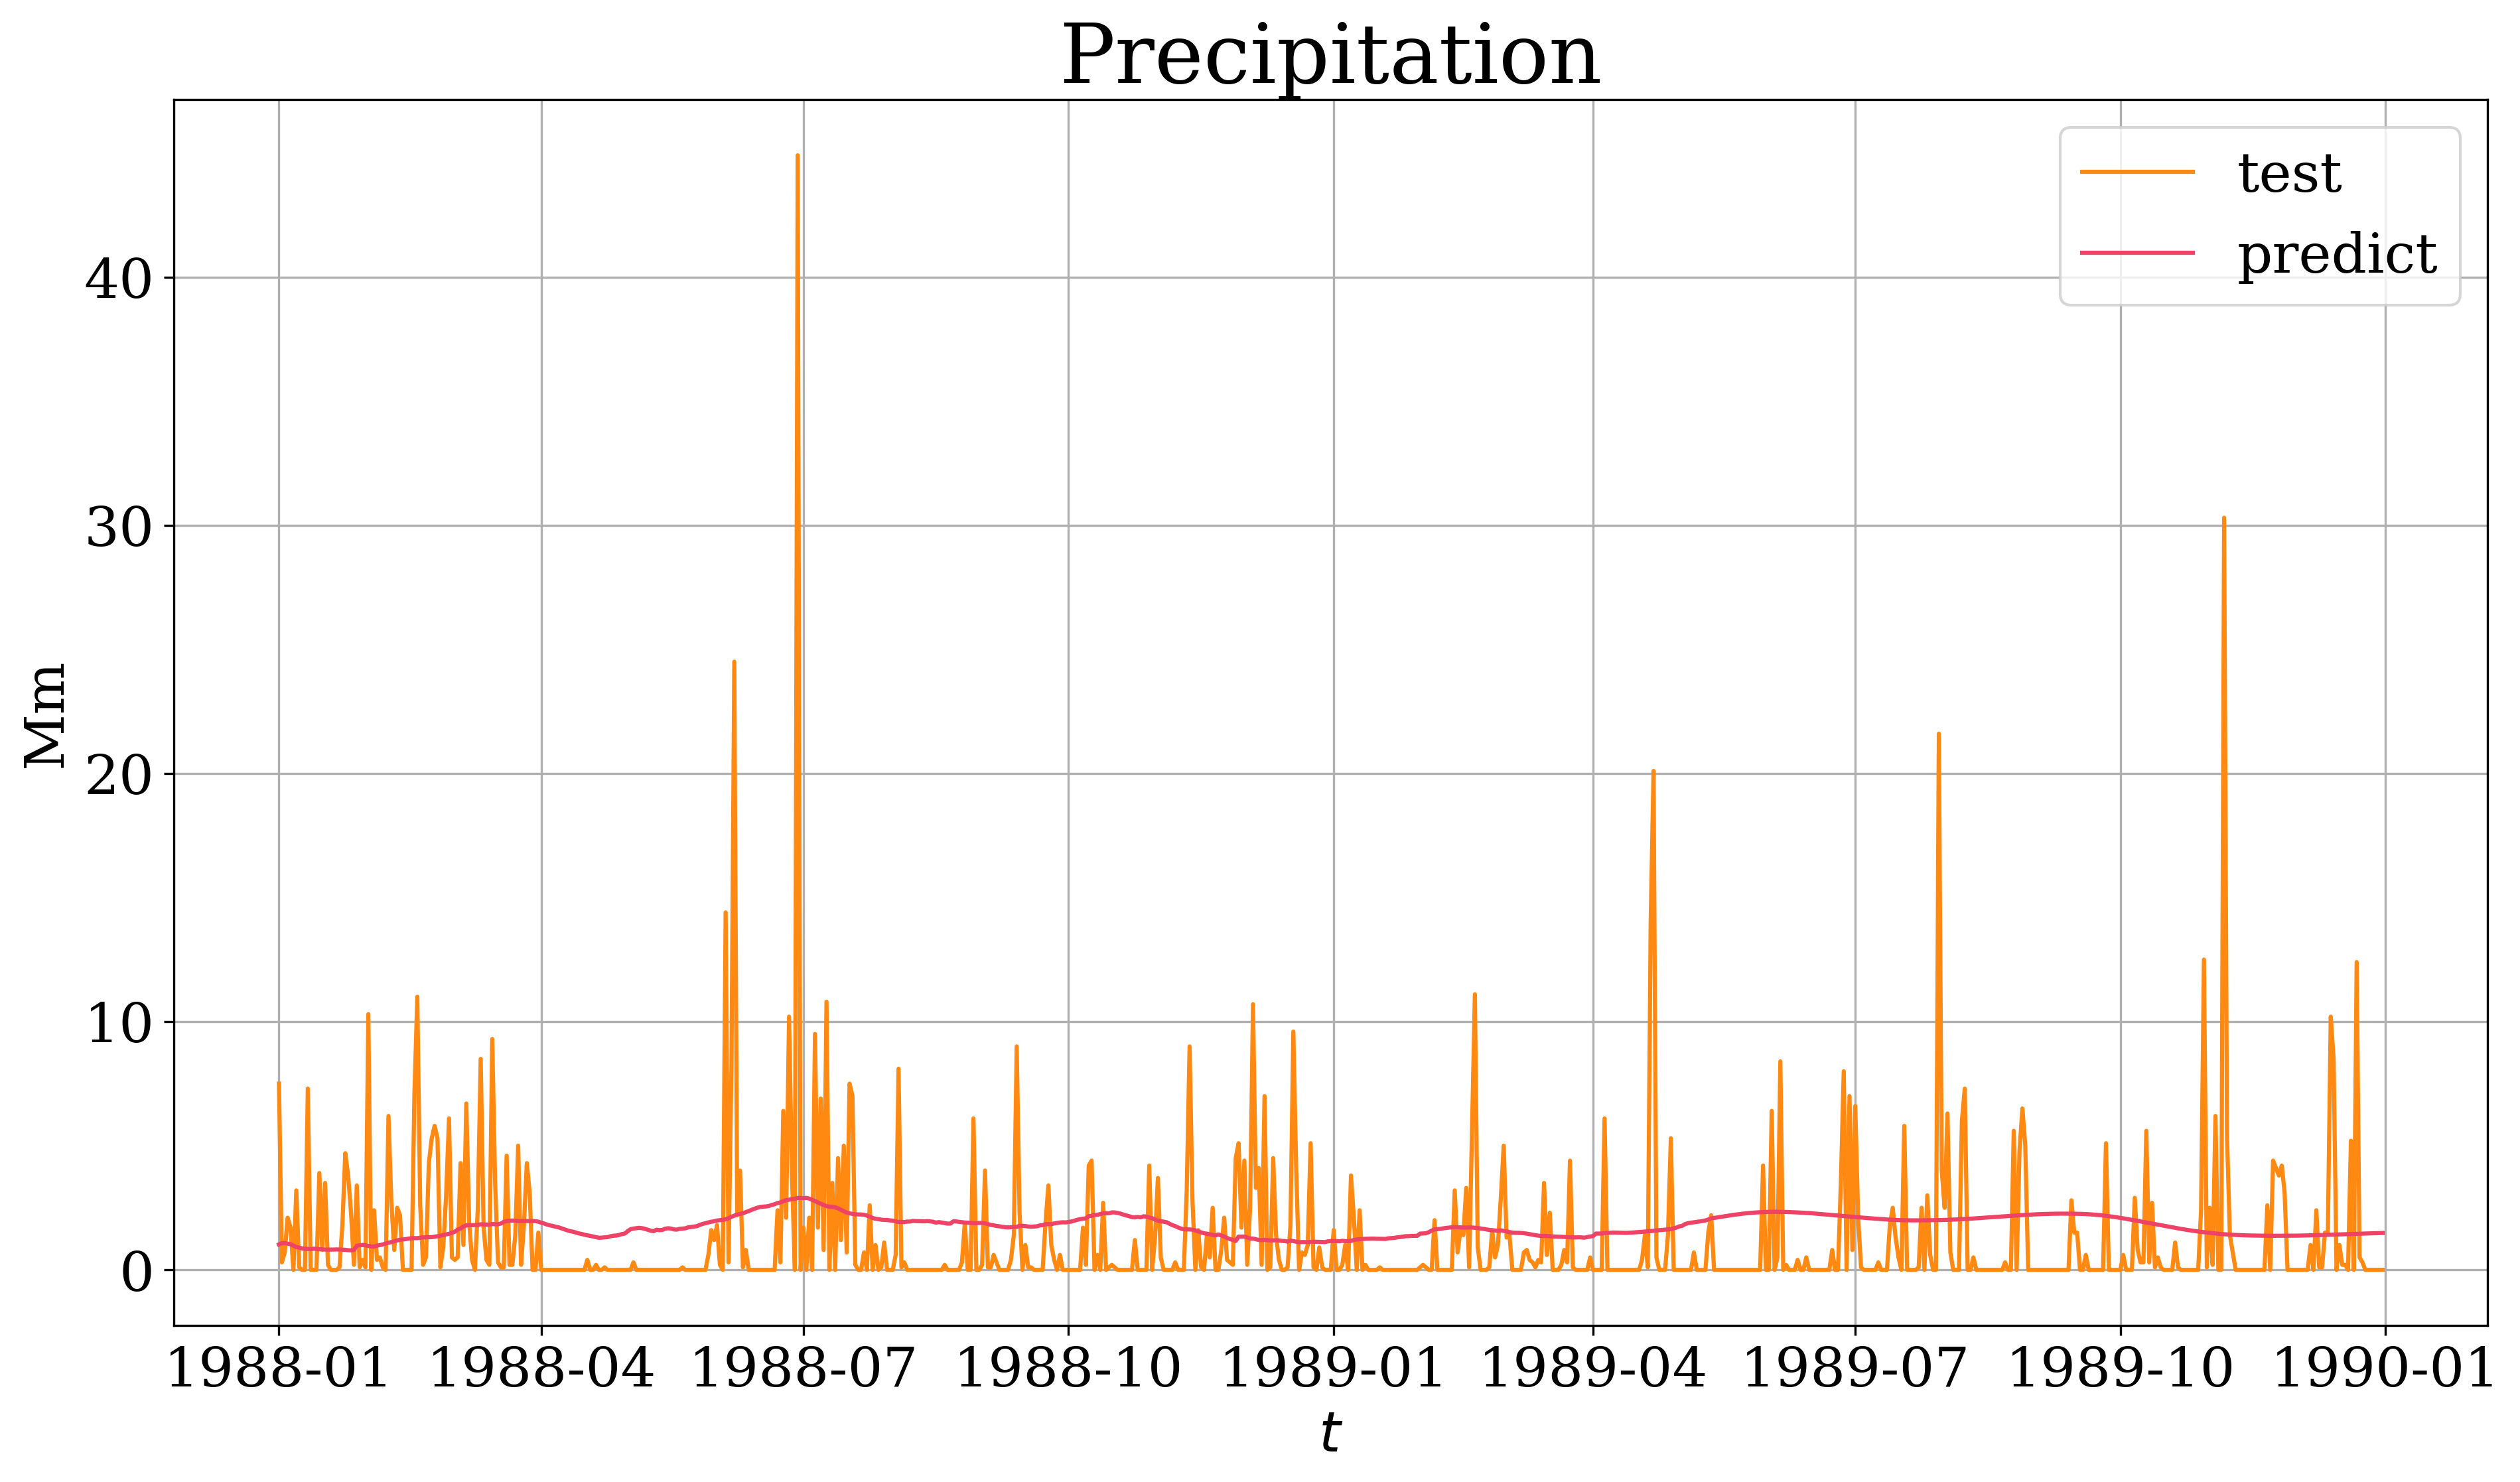

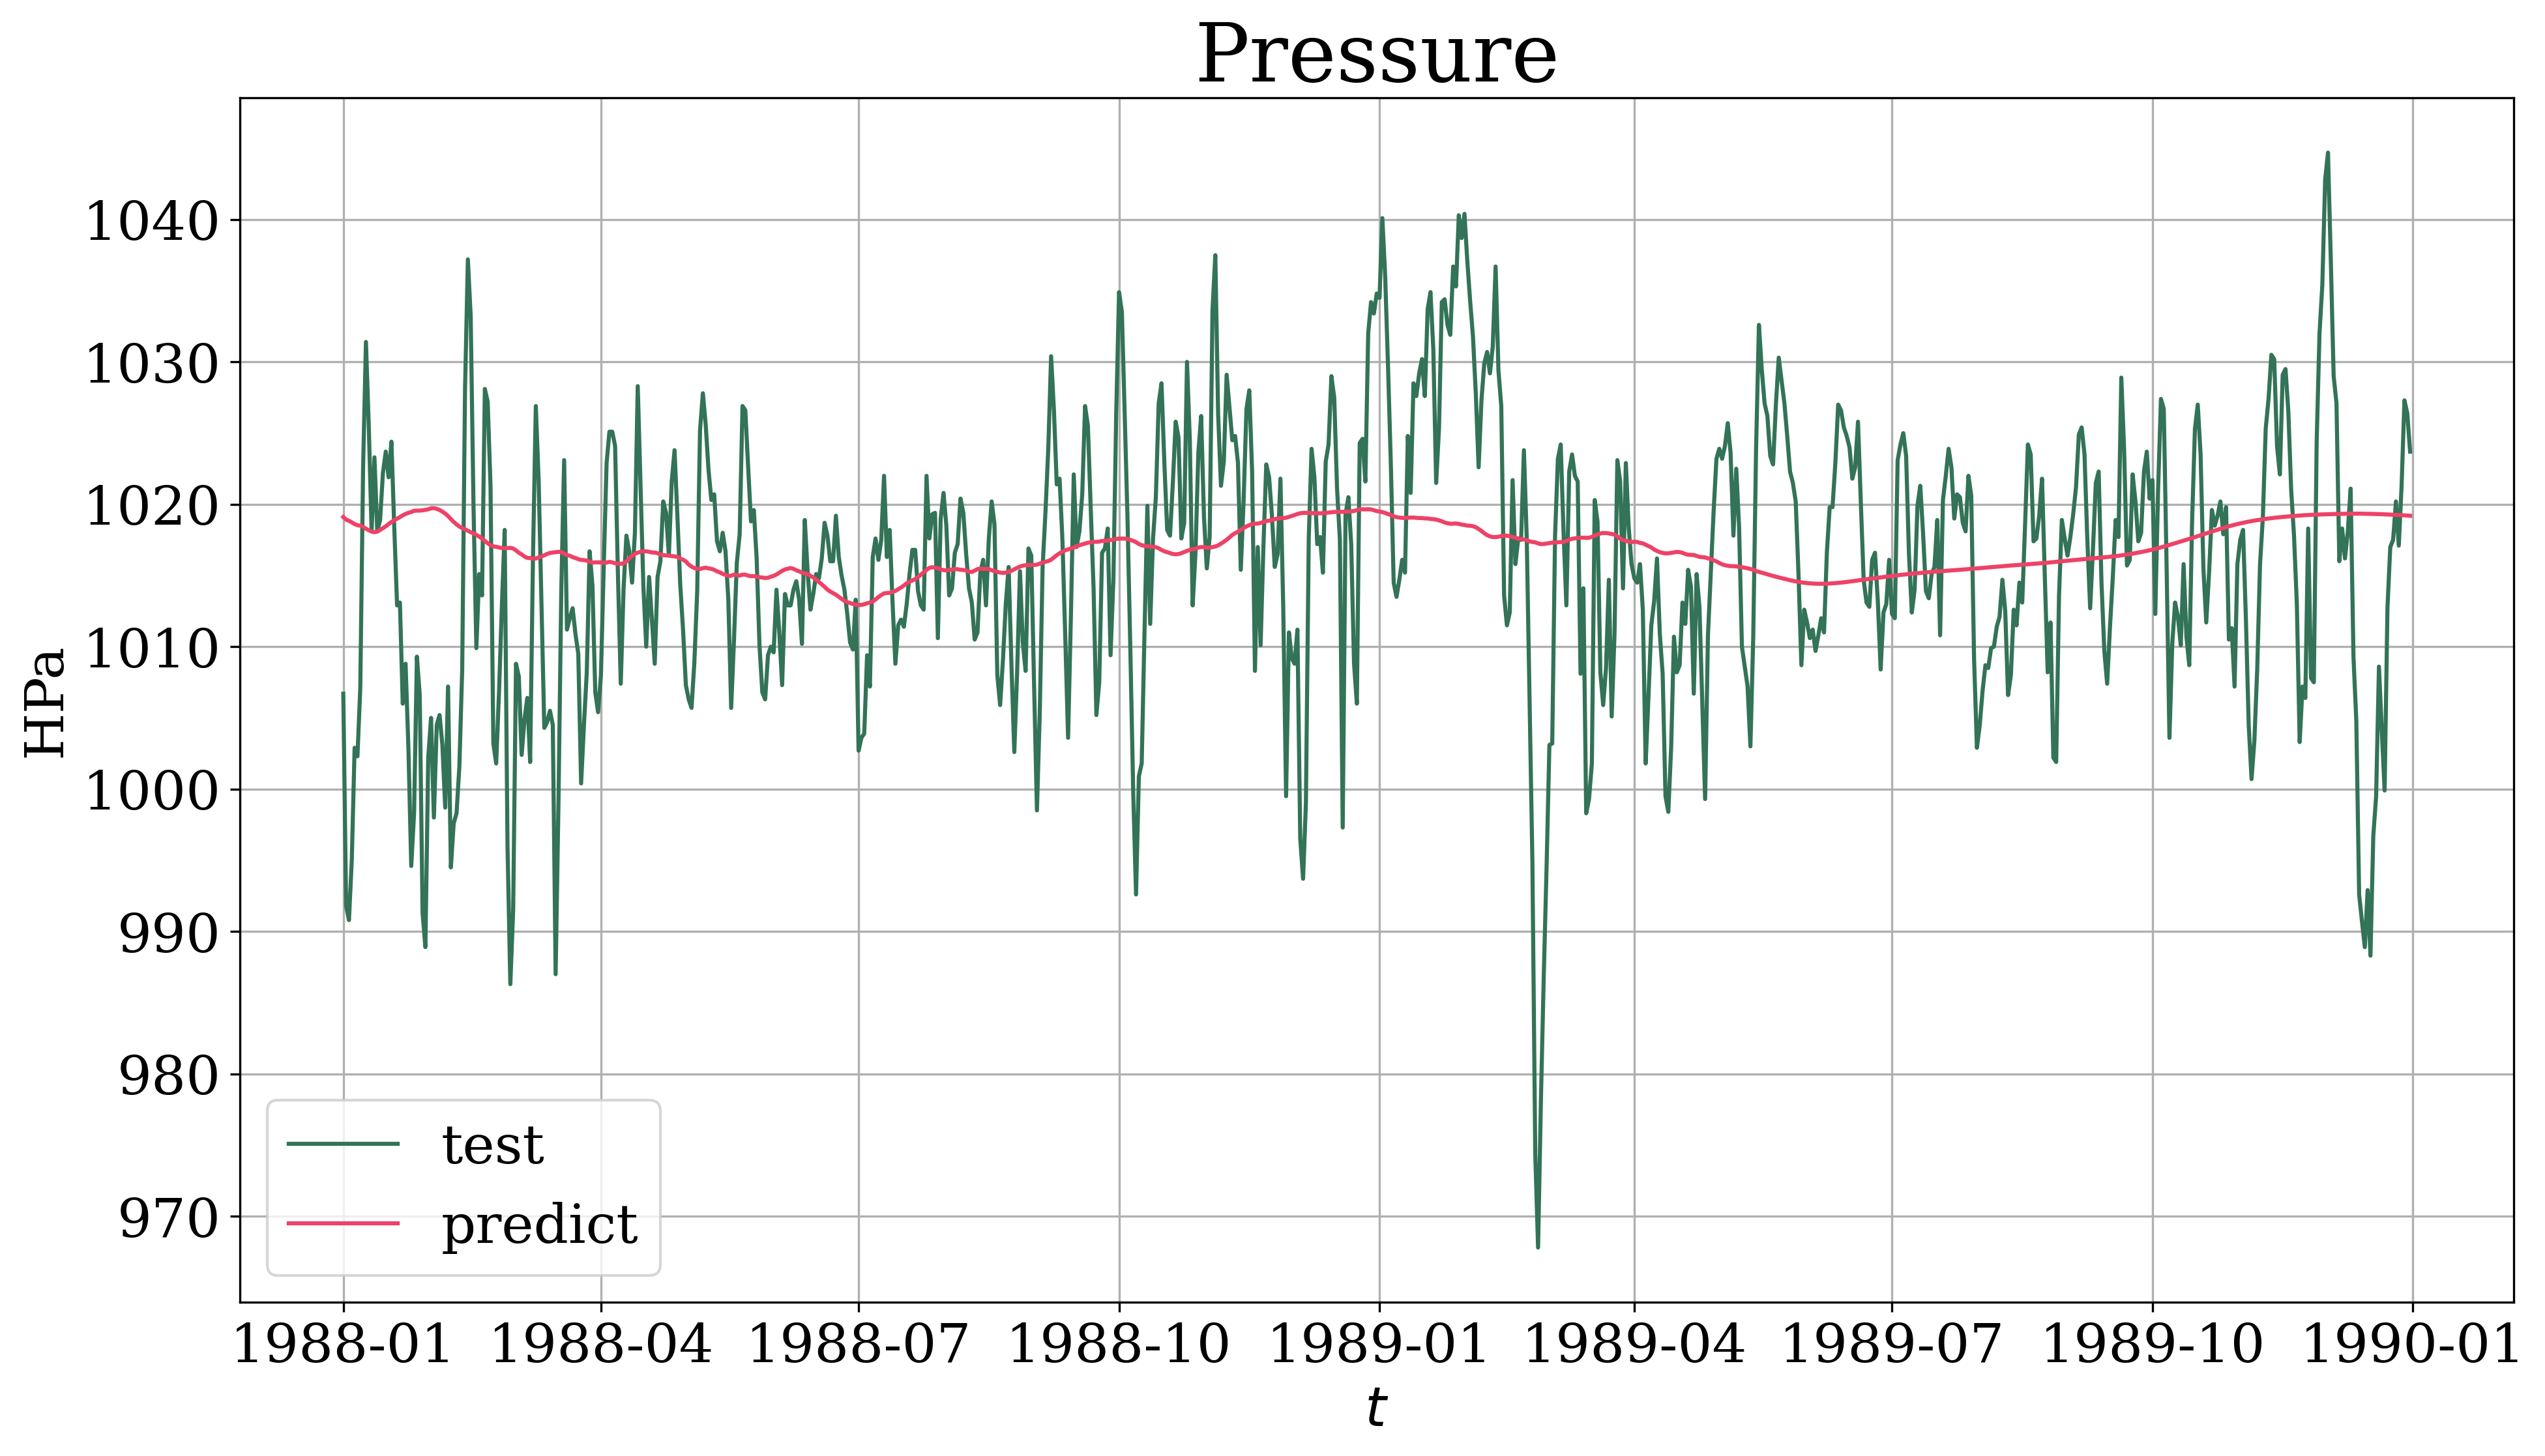

In [19]:
# make directory for figures
pathlib.Path(f'./figs/prediction/cpd_rank_5').mkdir(parents=True, exist_ok=True)

with open(f'./saved_model/cpd_rank_5.pkl', 'rb') as f:
        t_ssa_obj = pickle.load(f)

t_ssa_obj.remove_last_predictions()

# get prediction for cuurent number of factors left
forecast_tssa = np.empty(test_data.shape)

for i in range(test_data.shape[0]):
    forecast_tssa[i] = np.array(t_ssa_obj.predict_next())

for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, forecast_tssa.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/cpd_rank_5/{sig_names[i].replace(" ", "_")}.png',
                             format='png')